In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Drug attrition oracle

Use this notebook to predict whether an input molecule has a potential to be withdrawn. These models were trained on molecules that have passed phase 3 clinical trials, so the majority of whithdrawal reasons were related to adverse reaction (i.e. toxic sie effects)

In [3]:
from dao import DrugAttritionOracle

Initialize the model

In [4]:
dao = DrugAttritionOracle()

Global seed set to 0


Model takes as input a smiles string of a molecule: e.g. azithromycin canoical smiles

In [5]:
azithromycin = "CCC1C(C(C(N(CC(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(O2)C)O)(C)OC)C)OC3C(C(CC(O3)C)N(C)C)O)(C)O)C)C)C)O)(C)O"

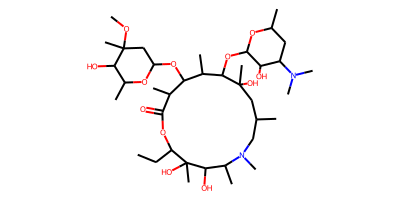

In [6]:
dao.draw_molecule(azithromycin)

You can input any format of valid SMILES, however we recommend standardizing the SMILES. (Standardization won't affect azithromycin canonical smiles)

In [7]:
standardized_azithro = dao.standardize_molecule(azithromycin)

Return the probability from the model

In [8]:
dao.predict_probability(standardized_azithro)

77.06

Predict class based on a threshold given by the optimal F1 score for the withdrawn class

In [10]:
dao.predict_class(standardized_azithro)

'Approved'

Find the probability of outputting the correct class using the conformal predictor. Without inputing a significance level the conformal method outputs a p-value, which can be interpreted as: 
  * With probability equal to the p-value, the model can produce the correct prediction

In [11]:
dao.conformal(standardized_azithro)

,Withdrawn class p-value,Approved class p-value
0,0.57,0.56


You can also enter a significance level which can be interpreted as:
   * The classifier will output a prediction with an error rate of at most equal to the specified significance level

In [12]:
dao.conformal(standardized_azithro, significance=0.05)

,Withdrawn class,Approved class
0,False,False


* We can see that the model can't make predictions that confident for this molecule

We use GNN explainer to interpret the model. It finds the edges that are most important to making the prediction for the given input molecule. This can be used to find molecular substructures importat for the prediction of withdrawn drugs. GNN explainer also outputs importance of the atom features

Explain graph: 100%|██████████| 300/300 [00:09<00:00, 31.81it/s]


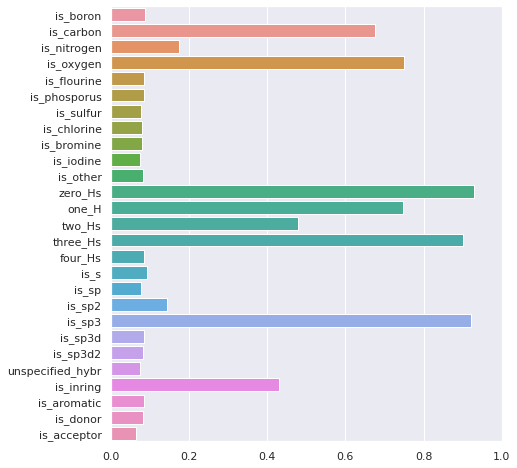

In [105]:
dao.explain_molecule_features(standardized_azithro)

Explain graph: 100%|██████████| 300/300 [00:08<00:00, 33.58it/s]


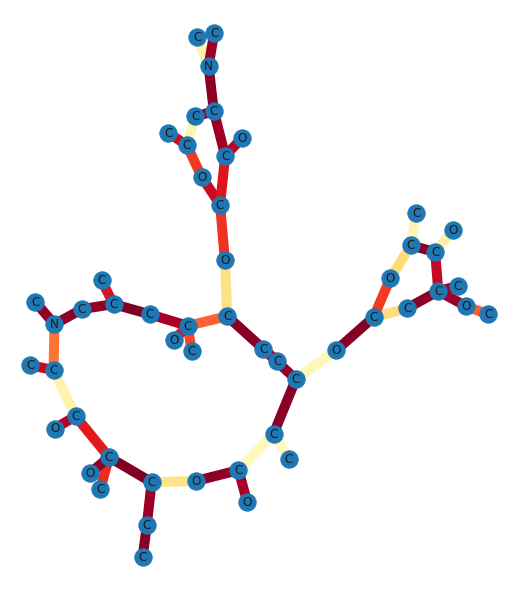

In [111]:
dao.explain_subgraphs(standardized_azithro)